In [1]:
from pygtrie import Trie, StringTrie

In [2]:
st = StringTrie()
st

StringTrie([], separator='/')

In [3]:
st['dog'] = 1
st['dog/cat'] = 2
st['monkey'] = 3
st

StringTrie([('dog', 1), ('dog/cat', 2), ('monkey', 3)], separator='/')

In [7]:
st.longest_prefix('dog/cat')

('dog/cat': 2)

In [8]:
st.longest_prefix('dog')

('dog': 1)

## My version

In [870]:
from copy import deepcopy
from functools import partial

from htools import *
from lolviz import *

In [1089]:
class TrieNode:
    
    def __init__(self, data=()):
        self.edges = {}
        self.stop_state = False
        for x in data:
            self.append(x)
        
    def append(self, seq):
        if not seq: 
            self.stop_state = True
            return
        x = seq[0]
        if x not in self.edges:
            self.edges[x] = TrieNode()
        self.edges[x].append(seq[1:])
        
    def __repr__(self):
        return f'{type(self).__name__}({list(self.edges.keys()) or ""})'

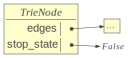

In [1090]:
node = TrieNode()
objviz(node)

In [1091]:
node

TrieNode()

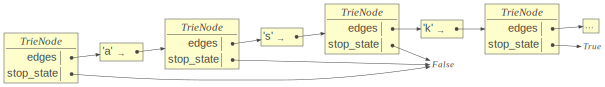

In [1092]:
node.append('ask')
objviz(node)

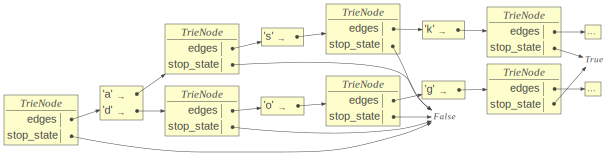

In [1093]:
node.append('dog')
objviz(node)

In [1094]:
node

TrieNode(['a', 'd'])

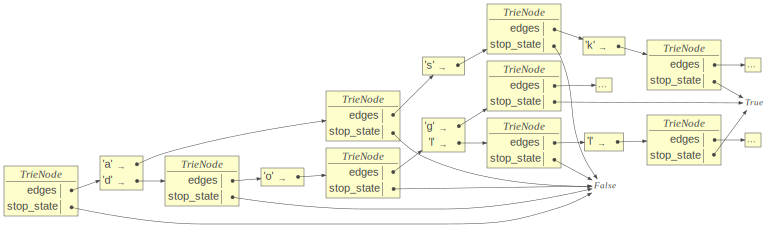

In [1095]:
node.append('doll')
objviz(node)

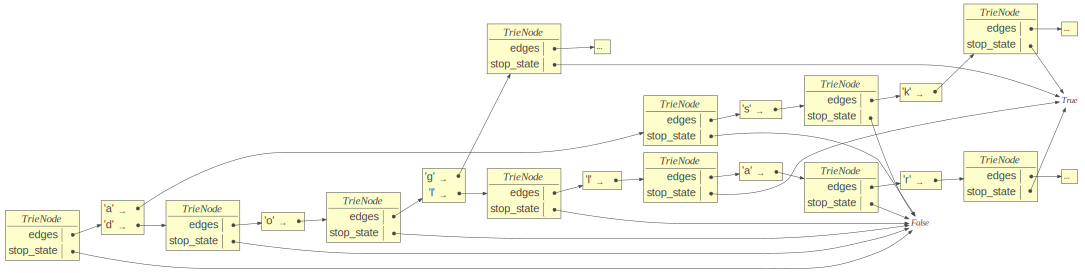

In [1096]:
node.append('dollar')
objviz(node)

In [1097]:
TrieNode(['dog', 'cat'])

TrieNode(['d', 'c'])

In [1098]:
x = 6
type([]).__name__

'list'

In [3089]:
class Trie:
    
    def __init__(self, data=(), suffix=False):
        """
        Parameters
        ----------
        data: str or list-like Iterable
            If provided, this should be one or more sequences to add to the
            try. Sequences could be strings, lists of strings (like word
            tokens), tuples of integers, etc. As of Dec 2020, this should NOT
            be numpy arrays or torch tensors.
        """
        self.head = TrieNode()
        if suffix:
            self._maybe_reverse = lambda x: x[::-1]
        else:
            self._maybe_reverse = identity
        self.suffix = suffix
            
        # dtype records the type of object present in the trie, and is a
        # string rather than a type because lolviz library has a
        # bug when displaying type attributes. Its visualizations are very
        # helpful here so I don't want to break compatibility.
        self.dtype = ''
        self.child_dtype = ''
        self.postprocess = None
        self.extend(tolist(data))
        
    def append(self, seq):
        """Add a sequence to the trie. This operates in place."""
        if not self.postprocess: 
            self.dtype = type(seq).__name__
            self.child_dtype = type(seq[0]).__name__
            self.postprocess = partial(str.join, '') if self.dtype == 'str' \
                else identity
        else:
            self._validate_input(seq)
        self.head.append(self._maybe_reverse(seq))
        
    def extend(self, seqs):
        """Add a list-like group of sequences to the Trie."""
        for seq in seqs:
            self.append(seq)
            
    def __add__(self, seq):
        """Allows us to add items to a trie using + operator. This does not 
        alter the trie in place: to do that, use `append` or assign the result
        of this method back to your variable.
        
        Returns
        -------
        Trie
        """
        clone = deepcopy(self)
        clone.append(seq)
        return clone
    
    def _find(self, seq, node=None):
        """Try to find a a sequence in the trie. We provide this helper method
        rather than doing it entirely in __contains__ in case other methods
        want to make use of the found node (perhaps passing it to 
        self._values.)
        
        Returns
        -------
        TrieNode: If node.stop_state=True, the seq is in the trie. If False,
        it's not.
        """
        seq = self._maybe_reverse(self._validate_input(seq))
        node = node or self.head
        for x in seq:
            if x not in node.edges: return TrieNode()
            node = node.edges[x]
        return node
    
    def __contains__(self, seq):
        """Check if a sequence is present in the trie.
        
        Returns
        -------
        bool
        """
        return self._find(seq).stop_state
    
    def _values(self, current=None, node=None):
        """Generator that yields each sequence in the tree one by one. Don't
        rely on the order, but I believe it should be a depth first traversal
        where the order of subtries traversed is determined by insertion 
        order. See examples.
        
        Parameters
        ----------
        current: list or None
            List of partial sequence currently being retrieved. This is used
            internally but should rarely need to be called by the user.
        node: TrieNode or None
            The node to retrieve values from. By default, we use the root 
            node, thereby retrieving values for the whole trie.
        
        Examples
        --------
        >>> t = Trie(['add', 'subtract', 'addition', 'multiply', 'adds'])
        >>> for v in t._values():
               print(v)
            
        add
        addition
        adds
        subtract
        multiply
        """
        node = node or self.head
        current = current or []
        if node.stop_state:
            # Here, reversal is more of a postprocessing step than a 
            # preprocessing one: we're converting the reversed word stored in
            # the suffix tree back to its original order.
            yield self._maybe_reverse(self.postprocess(current))
        for key, node_ in node.edges.items():
            yield from self._values(current+[key], node_)
    
    def values(self):
        """Get a list of all sequences in the trie. Wrapper for `_values`
        that returns a list rather than a generator.
        """
        return list(self._values())
    
    def _startswith(self, seq, node=None):
        """Base behavior for both `startswith` and `endswith`.
        """
        node = self._find(seq, node=node)
        if self.suffix: 
            return [x + seq for x in self._values(node=node)]
        else:
            return [seq + x for x in self._values(node=node)]

    def startswith(self, seq, node=None):
        """
        """
        if self.suffix:
            warnings.warn(
                'Suffix trees are optimized for the `endswith` method, but '
                '`startswith` will require walking the whole trie (may be '
                'slow). For an efficient implementation of `startswith`, you '
                'can create a prefix tree by passing `suffix=False` to '
                'Trie.__init__.'
            )
            if self.dtype == 'str':
                return [v for v in self._values(node=node) 
                        if v.startswith(seq)]
            else:
                self._validate_input(seq)
                length = len(seq)
                return [v for v in self._values(node=node)
                        if v[:length] == seq]
        return self._startswith(seq, node=node)

    def endswith(self, seq, node=None):
        """
        """
        if not self.suffix:
            warnings.warn(
                'Prefix trees are optimized for the `startswith` method, but '
                '`endswith` will require walking the whole trie (may be '
                'slow). For an efficient implementation of `endswith`, you '
                'can create a suffix tree by passing `suffix=True` to '
                'Trie.__init__.'
            )
            if self.dtype == 'str':
                return [v for v in self._values(node=node) 
                        if v.endswith(seq)]
            else:
                self._validate_input(seq)
                length = len(seq)
                return [v for v in self._values(node=node) 
                        if v[-length:] == seq]
        return self._startswith(seq, node=node)

    def _longest_common_prefix(self, seq, seen):
        """Base functionality for the efficient version of 
        `longest_common_prefix` for prefix trees and `longest_common_suffix`
        for suffix trees.
        
        Parameters
        ----------
        seq: Iterable
            Input sequence for which you wish to find sequences with matching
            prefixes (or suffixes). Type must match that of the other 
            sequences in the trie.
        seen: list
            Empty list passed in. Seems to be necessary to accumulate matches.
            
        Returns
        -------
        list: Each item in the list is of the same tyep as `seq`. An empty 
        list means no items in the tree share a common prefix with `seq`.
        """
        # Validation and reversal happens in `startswith`.
        matches = self.endswith(seq) if self.suffix else self.startswith(seq)
        if matches: return matches
        node = self.head
        for i, x in enumerate(self._maybe_reverse(seq)):
            if x in node.edges:
                seen.append(x)
                node = node.edges[x]
            elif i == 0:
                # Otherwise, all values are returned when the first item is 
                # not in the trie.
                return []
            else:
                seen = self._maybe_reverse(self.postprocess(seen))
                if self.suffix:
                    matches = [v + seen for v in self._values(node=node)]
                else:
                    matches = [seen + v for v in self._values(node=node)]
                # Otherwise, we get bug where an empty list is returned if
                # the longest matching prefix is a complete sequence and the
                # node has no edges.
                if node.stop_state and not matches: 
                    matches.append(seen)
                return matches
        
        # Case where the input sequence is present in the trie as a complete
        # sequence and it has no edges. This cannot be combined with the
        # case in the else statement above where matches is empty. We avoid
        # handling this upfront with something like 
        # `if seq in self: return [seq]` because we want to capture additional
        # valid sequences in present.
        if node.stop_state:
            return [self._maybe_reverse(self.postprocess(seen))]
    
    def longest_common_prefix(self, seq):
        """Find sequences that share a common prefix with an input sequence.
        For instance, "carry" shares a common prefix of length 3 with "car",
        "carton", and "carsick", a common prefix of length 1 with "chat", and
        no common prefix with "dog". Note that a word shares a common prefix 
        with itself, so if it's present in the trie it will be returned (in 
        addition to any words that begin with that substring: for instance, 
        both "carry" and "carrying" share a common prefix of length 5 with 
        "carry".)
        
        Parameters
        ----------
        seq: Iterable
            Input sequence for which you wish to find sequences with matching
            prefixes. Type must match that of the other 
            sequences in the trie.
            
        Returns
        -------
        list: Each item in the list is of the same tyep as `seq`. An empty 
        list means no items in the tree share a common prefix with `seq`.
        """
        # Validation occurs in self.startswith, often via self._find.
        if not self.suffix:
            return self._longest_common_prefix(seq, [])
        
        warnings.warn(
            'Suffix trees are optimized for the `longest_common_suffix` '
            'method, but `longest_common_prefix` will require walking '
            'the whole trie (may be slow). For an efficient implementation '
            'of `longest_common_prefix`, you can create a prefix tree by '
            'passing `suffix=False` to Trie.__init__.'
        )
        self._validate_input(seq)
        res = []
        for i in range(len(seq), 0, -1):
            for v in self._values():
                if v[:i] == seq[:i]: res.append(v)
            if res: break
        return res
    
    def longest_common_suffix(self, seq):
        # TODO: testing generator values
        # TODO: update docs and warning message
        """Find sequences that share a common suffix with an input sequence.
        For instance, "carry" shares a common prefix of length 2 with "story",
        "tawdry", and "ornery", a common suffix of length 1 with "slowly", and
        no common suffix with "hate". Note that a word shares a common suffix 
        with itself, so if it's present in the trie it will be returned (in 
        addition to any words that end with that substring: for instance, both
        "carry" and "miscarry" share a common suffix of length 5 with 
        "carry".)
        
        Parameters
        ----------
        seq: Iterable
            Input sequence for which you wish to find sequences with matching
            suffixes. Type must match that of the other sequences in the trie.
            
        Returns
        -------
        list: Each item in the list is of the same tyep as `seq`. An empty 
        list means no items in the tree share a common prefix with `seq`.
        """
        # Validation and reversal occur in self.endswith, often via 
        # self._find.
        if self.suffix:
            return self._longest_common_prefix(seq, [])
        
        warnings.warn(
            'Prefix trees are optimized for the `longest_common_prefix` '
            'method, but `longest_common_suffix` will require walking the '
            'whole trie (may be slow and memory intensive). For an '
            'efficient implementation of `longest_common_suffix`, you can '
            'create a suffix tree by passing `suffix=True` to Trie.__init__.'
        )
        self._validate_input(seq)
        res = []
        for i in range(len(seq), 0, -1):
            for v in self._values():
                if v[-i:] == seq[-i:]: res.append(v)
            if res: break
        return res
    
    def _validate_input(self, seq):
        """This should occur before calling self._maybe_reverse. Seq must be
        the same type as the other items in the trie or an error will be
        raised.
        """
        if type(seq).__name__ != self.dtype:
            raise TypeError('`seq` type doesn\'t match type of other '
                            'sequences.')
        if type(seq[0]).__name__ != self.child_dtype:
            raise TypeError('Type of first item in `seq` doesn\'t match type '
                            'of first item in other sequences.')
            
    def reverse(self):
        return type(self)(self.values(), suffix=not self.suffix)
    
    # TODO: wishlist
    """
    -some sort of distance(seq1, seq2) method
    -typos/neighbors (see Terence's slides)
    -let user pass in kv pair (e.g. could use this as a w2i dict). However,
    I think this might require a dramatically different interface. Or could I
    just make it so that we only use this functionality if you pass in a dict
    or list of dicts? Prob much slower than a dict so I don't know if we'd
    actually want to use it in that case. Passing in a dict might also be
    problematic for my reversal function and type checking.
    """

### T - str

In [2964]:
t = Trie(['dolphin', 'deer'], suffix=False)

In [2965]:
t.append('star')
t.append('study')
t.append('apple')
t.append('larkin')
t.append('app')
t.append('castle')
t.append('lake')
t.append('cake')

In [2966]:
t.values()

['dolphin',
 'deer',
 'star',
 'study',
 'app',
 'apple',
 'larkin',
 'lake',
 'castle',
 'cake']

In [2967]:
t.endswith('hin')

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:207: UserWarning: Prefix trees are optimized for the `startswith` method, but `endswith` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `endswith`, you can create a suffix tree by passing `suffix=True` to Trie.__init__.


['dolphin']

In [2968]:
# Notice endswith no longer throws warning because it's a suffix tree now.
t.reverse().endswith('hin')

['dolphin']

In [2969]:
assert 'app' in t
assert 'apple' in t
assert 'ap' not in t
assert 'appleton' not in t
assert 'fox' not in t

In [2970]:
tmp = t + 'candy'
assert 'candy' in tmp
assert not 'candy' in t

In [2971]:
t += 'car'
t += 'stunning'
t += 'stir'
t += 'sorry'

In [2972]:
t.extend(['sturdy', 'stipend', 'cold'])

In [2973]:
t.startswith('stu')

['study', 'stunning', 'sturdy']

In [2974]:
t.startswith('ap')

['app', 'apple']

In [2975]:
t.startswith('ca')

['castle', 'cake', 'car']

In [2976]:
t.startswith('zzz')

[]

In [2977]:
t.endswith('ke')

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:207: UserWarning: Prefix trees are optimized for the `startswith` method, but `endswith` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `endswith`, you can create a suffix tree by passing `suffix=True` to Trie.__init__.


['lake', 'cake']

In [2978]:
with assert_raises(TypeError):
    t.startswith(['n'])

As expected, got TypeError(`seq` type doesn't match type of other sequences.).


In [2979]:
with assert_raises(TypeError):
    t += ['a', 'b']

As expected, got TypeError(`seq` type doesn't match type of other sequences.).


In [2980]:
t.values()

/Users/hmamin/anaconda3/lib/python3.7/site-packages/IPython/core/displayhook.py:276: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


['dolphin',
 'deer',
 'star',
 'study',
 'stunning',
 'sturdy',
 'stir',
 'stipend',
 'sorry',
 'app',
 'apple',
 'larkin',
 'lake',
 'castle',
 'cake',
 'car',
 'cold']

In [2981]:
# TODO: version of assert that prints result? I like to see output just to 
# make sure even though it shouldn't matter.
res = t.longest_common_prefix('applicable')
print(res)
assert res == ['apple']

['apple']


In [2982]:
res = t.longest_common_prefix('app')
print(res)
assert res == ['app', 'apple']

['app', 'apple']


In [2983]:
res = t.longest_common_prefix('apple')
print(res)
assert res == ['apple']

['apple']


In [2984]:
res = t.longest_common_prefix('appleton')
print(res)
assert res == ['apple']

['apple']


In [2985]:
res = t.longest_common_prefix('candid')
print(res)
assert res == ['castle', 'cake', 'car']

['castle', 'cake', 'car']


In [2986]:
res = t.longest_common_prefix('zoo')
print(res)
assert res == []

[]


In [2987]:
res = t.longest_common_prefix('castlegate')
print(res)
assert res == ['castle']

['castle']


In [2988]:
res = t.longest_common_prefix('apptive')
print(res)
assert res == ['app', 'apple']

['app', 'apple']


In [2989]:
res = t.longest_common_prefix('card')
print(res)
assert res == ['car']

['car']


In [2990]:
with assert_raises(TypeError):
    t.longest_common_prefix(['abc', 'def'])

As expected, got TypeError(`seq` type doesn't match type of other sequences.).


In [2991]:
# brute force method
res = t.longest_common_suffix('ornery')
print(res)
assert res == ['sorry']

['sorry']


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:483: UserWarning: Prefix trees are optimized for the `longest_common_prefix` method, but `longest_common_suffix` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `longest_common_suffix`, you can create a suffix tree by passing `suffix=True` to Trie.__init__.


In [2992]:
# brute force method
res = t.longest_common_suffix('stir')
print(res)
assert res == ['stir']

['stir']


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:483: UserWarning: Prefix trees are optimized for the `longest_common_prefix` method, but `longest_common_suffix` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `longest_common_suffix`, you can create a suffix tree by passing `suffix=True` to Trie.__init__.


In [2993]:
# brute force method
res = t.longest_common_suffix('stirring')
print(res)
assert res == ['stunning']

['stunning']


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:483: UserWarning: Prefix trees are optimized for the `longest_common_prefix` method, but `longest_common_suffix` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `longest_common_suffix`, you can create a suffix tree by passing `suffix=True` to Trie.__init__.


In [2994]:
# brute force method
res = t.longest_common_suffix('nest')
print(res)
assert res == []

[]


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:483: UserWarning: Prefix trees are optimized for the `longest_common_prefix` method, but `longest_common_suffix` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `longest_common_suffix`, you can create a suffix tree by passing `suffix=True` to Trie.__init__.


### T2: list[str]

Each sequence is a list of strings (NOT nested).

In [2995]:
t2 = Trie()
t2.append(['I',  'went', 'to', 'school', 'today', '.'])
t2.append(['I',  'like', 'horses', '.'])
t2.append(['He', 'is', 'home', 'early', '.'])
t2.append(['I', 'went', 'to', 'the', 'beach', '.'])

In [2996]:
t2.values()

[['I', 'went', 'to', 'school', 'today', '.'],
 ['I', 'went', 'to', 'the', 'beach', '.'],
 ['I', 'like', 'horses', '.'],
 ['He', 'is', 'home', 'early', '.']]

In [2997]:
t2.startswith(['I'])

[['I', 'went', 'to', 'school', 'today', '.'],
 ['I', 'went', 'to', 'the', 'beach', '.'],
 ['I', 'like', 'horses', '.']]

In [2998]:
t2.endswith(['today', '.'])

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:207: UserWarning: Prefix trees are optimized for the `startswith` method, but `endswith` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `endswith`, you can create a suffix tree by passing `suffix=True` to Trie.__init__.


[['I', 'went', 'to', 'school', 'today', '.']]

In [2999]:
t2.endswith(['.'])

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:207: UserWarning: Prefix trees are optimized for the `startswith` method, but `endswith` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `endswith`, you can create a suffix tree by passing `suffix=True` to Trie.__init__.


[['I', 'went', 'to', 'school', 'today', '.'],
 ['I', 'went', 'to', 'the', 'beach', '.'],
 ['I', 'like', 'horses', '.'],
 ['He', 'is', 'home', 'early', '.']]

In [3000]:
t2.extend([['Hot', 'chocolate'], ['sandy', 'beach']])

In [3001]:
with assert_raises(TypeError):
    t2.startswith('h')

As expected, got TypeError(`seq` type doesn't match type of other sequences.).


In [3002]:
with assert_raises(TypeError):
    t2 += (3, 4)

As expected, got TypeError(`seq` type doesn't match type of other sequences.).


In [3003]:
with assert_raises(TypeError):
    t2.append([1, 2, 3])

As expected, got TypeError(Type of first item in `seq` doesn't match type of first item in other sequences.).


In [3004]:
res = t2.longest_common_prefix(['I', 'went', 'to', 'the', 'movies', 
                                'yesterday', '.'])
print(res)
assert res == [['I', 'went', 'to', 'the', 'beach', '.']]

[['I', 'went', 'to', 'the', 'beach', '.']]


In [3005]:
res = t2.longest_common_prefix(['I', 'went', 'to', 'an', 'amusement', 'park',
                                '.'])
print(res)
assert res == [['I', 'went', 'to', 'school', 'today', '.'],
               ['I', 'went', 'to', 'the', 'beach', '.']]

[['I', 'went', 'to', 'school', 'today', '.'], ['I', 'went', 'to', 'the', 'beach', '.']]


In [3006]:
res = t2.longest_common_prefix(['You', 'can', 'sometimes', 'tell', 'the', 
                                'difference', '.'])
print(res)
assert res == []

[]


In [3007]:
# brute force
res = t2.longest_common_suffix(['Who', 'is', 'there', '?'])
print(res)
assert res == []

[]


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:483: UserWarning: Prefix trees are optimized for the `longest_common_prefix` method, but `longest_common_suffix` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `longest_common_suffix`, you can create a suffix tree by passing `suffix=True` to Trie.__init__.


In [3008]:
# brute force
res = t2.longest_common_suffix(['Hmm', '.'])
print(res)
assert res == [['I', 'went', 'to', 'school', 'today', '.'],
               ['I', 'went', 'to', 'the', 'beach', '.'],
               ['I', 'like', 'horses', '.'],
               ['He', 'is', 'home', 'early', '.']]

[['I', 'went', 'to', 'school', 'today', '.'], ['I', 'went', 'to', 'the', 'beach', '.'], ['I', 'like', 'horses', '.'], ['He', 'is', 'home', 'early', '.']]


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:483: UserWarning: Prefix trees are optimized for the `longest_common_prefix` method, but `longest_common_suffix` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `longest_common_suffix`, you can create a suffix tree by passing `suffix=True` to Trie.__init__.


In [3009]:
t2.values()

[['I', 'went', 'to', 'school', 'today', '.'],
 ['I', 'went', 'to', 'the', 'beach', '.'],
 ['I', 'like', 'horses', '.'],
 ['He', 'is', 'home', 'early', '.'],
 ['Hot', 'chocolate'],
 ['sandy', 'beach']]

### T3: list[tuple[str]]

Each sequence is a list of tuples where each tuple contains one or more strings (nested).

In [3010]:
ex = [
    'It is cold and windy.',
    'The food was still hot.',
    'It is not warm.',
    'The cow mooed loudly.',
    'It is cold and snowy.'
]

t3 = Trie()
for e in ex:
    item = list(map(tuple, ngrams(e.split(), 2, 2, False)))
    print(item)
    t3.append(item)

[('It', 'is'), ('cold', 'and'), ('windy.',)]
[('The', 'food'), ('was', 'still'), ('hot.',)]
[('It', 'is'), ('not', 'warm.')]
[('The', 'cow'), ('mooed', 'loudly.')]
[('It', 'is'), ('cold', 'and'), ('snowy.',)]


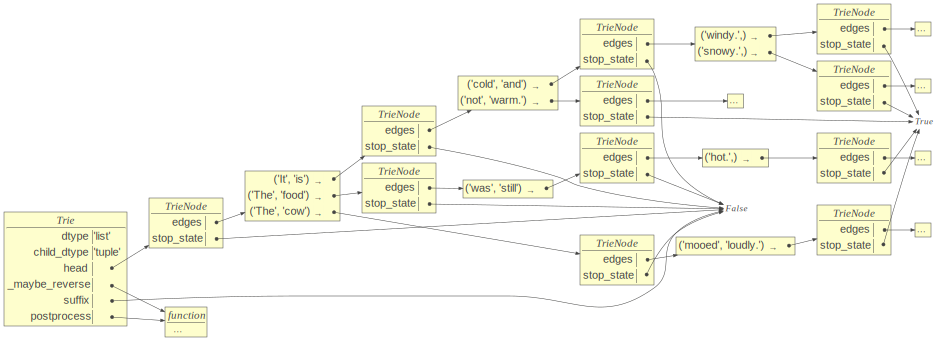

In [3011]:
objviz(t3)

In [3012]:
t3.values()

[[('It', 'is'), ('cold', 'and'), ('windy.',)],
 [('It', 'is'), ('cold', 'and'), ('snowy.',)],
 [('It', 'is'), ('not', 'warm.')],
 [('The', 'food'), ('was', 'still'), ('hot.',)],
 [('The', 'cow'), ('mooed', 'loudly.')]]

In [3013]:
with assert_raises(TypeError):
    t3.append(('It', 'is'))

As expected, got TypeError(`seq` type doesn't match type of other sequences.).


In [3014]:
with assert_raises(TypeError):
    t3.append(['It', 'is'])

As expected, got TypeError(Type of first item in `seq` doesn't match type of first item in other sequences.).


In [3015]:
t3.append([('It', 'is')])
t3.startswith([('It', 'is')])

[[('It', 'is')],
 [('It', 'is'), ('cold', 'and'), ('windy.',)],
 [('It', 'is'), ('cold', 'and'), ('snowy.',)],
 [('It', 'is'), ('not', 'warm.')]]

In [3016]:
t3.startswith([('It', 'is'), ('cold', 'and')])

[[('It', 'is'), ('cold', 'and'), ('windy.',)],
 [('It', 'is'), ('cold', 'and'), ('snowy.',)]]

In [3017]:
with assert_raises(TypeError):
    t3.startswith(['It', 'is', 'cold', 'and'])

As expected, got TypeError(Type of first item in `seq` doesn't match type of first item in other sequences.).


In [3084]:
res = t3.endswith([('mooed', 'loudly.')])
print(res)
assert res == [[('The', 'cow'), ('mooed', 'loudly.')]]

[[('The', 'cow'), ('mooed', 'loudly.')]]


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:207: UserWarning: Prefix trees are optimized for the `startswith` method, but `endswith` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `endswith`, you can create a suffix tree by passing `suffix=True` to Trie.__init__.


In [3085]:
res = t3.endswith([('mooed',)])
print(res)
assert not res

[]


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:207: UserWarning: Prefix trees are optimized for the `startswith` method, but `endswith` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `endswith`, you can create a suffix tree by passing `suffix=True` to Trie.__init__.


In [3020]:
t3.values()

[[('It', 'is')],
 [('It', 'is'), ('cold', 'and'), ('windy.',)],
 [('It', 'is'), ('cold', 'and'), ('snowy.',)],
 [('It', 'is'), ('not', 'warm.')],
 [('The', 'food'), ('was', 'still'), ('hot.',)],
 [('The', 'cow'), ('mooed', 'loudly.')]]

In [3021]:
res = t3.longest_common_prefix([('The', 'food'), ('never', 'came'), ('.',)])
print(res)
assert res == [[('The', 'food'), ('was', 'still'), ('hot.',)]]

[[('The', 'food'), ('was', 'still'), ('hot.',)]]


In [3022]:
res = t3.longest_common_prefix([('It', 'is'), ('cold', 'and'),
                                ('rainy', '.',)])
print(res)
assert res == [[('It', 'is'), ('cold', 'and'), ('windy.',)],
               [('It', 'is'), ('cold', 'and'), ('snowy.',)]]

[[('It', 'is'), ('cold', 'and'), ('windy.',)], [('It', 'is'), ('cold', 'and'), ('snowy.',)]]


In [3023]:
res = t3.longest_common_prefix([('It', 'is'), ('cold', 'and'), ('windy.',)])
print(res)
assert res == [[('It', 'is'), ('cold', 'and'), ('windy.',)]]

[[('It', 'is'), ('cold', 'and'), ('windy.',)]]


In [3024]:
res = t3.longest_common_prefix([('zigzag', 'hope')])
print(res)
assert not res

[]


In [3025]:
res = t3.longest_common_suffix([('So',), ('It', 'is')])
print(res)
assert res == [[('It', 'is')]]

[[('It', 'is')]]


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:483: UserWarning: Prefix trees are optimized for the `longest_common_prefix` method, but `longest_common_suffix` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `longest_common_suffix`, you can create a suffix tree by passing `suffix=True` to Trie.__init__.


### T4: list[int]

Each sequence is a list of integers (NOT nested).

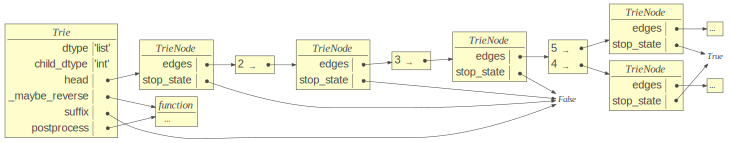

In [3026]:
t4 = Trie([[2, 3, 5], [2, 3, 4]])
objviz(t4)

In [3027]:
res = t4.startswith([2])
print(res)
assert res == [[2, 3, 5], [2, 3, 4]]

[[2, 3, 5], [2, 3, 4]]


In [3028]:
res = t4.endswith([3, 5])
print(res)
assert res == [[2, 3, 5]]

[[2, 3, 5]]


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:207: UserWarning: Prefix trees are optimized for the `startswith` method, but `endswith` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `endswith`, you can create a suffix tree by passing `suffix=True` to Trie.__init__.


In [3029]:
t4.append([1, 4, 9, 7, 5])
t4.extend([[2, 3, 5, 7], [2, 3, 1, 4, 99]])
t4.values()

[[2, 3, 5], [2, 3, 5, 7], [2, 3, 4], [2, 3, 1, 4, 99], [1, 4, 9, 7, 5]]

In [3030]:
res = t4.longest_common_prefix([2, 3, 1, 700, -1, 11])
print(res)
assert res == [[2, 3, 1, 4, 99]]

[[2, 3, 1, 4, 99]]


In [3031]:
# Consider what desired behavior is here. ValueError is an option too. 
with assert_raises(IndexError):
    t4.longest_common_prefix([])

As expected, got IndexError(list index out of range).


In [3032]:
res = t4.longest_common_suffix([1, 2, 5])
print(res)
assert res == [[2, 3, 5], [1, 4, 9, 7, 5]]

[[2, 3, 5], [1, 4, 9, 7, 5]]


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:483: UserWarning: Prefix trees are optimized for the `longest_common_prefix` method, but `longest_common_suffix` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `longest_common_suffix`, you can create a suffix tree by passing `suffix=True` to Trie.__init__.


### T5: list[tuple[int]]

Each sequence is a list of tuples where each tuple contains one or more ints (nested).

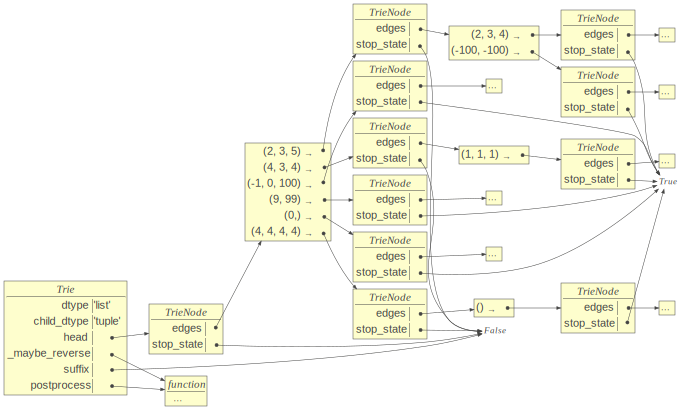

In [3033]:
t5 = Trie([[(2, 3, 5), (2, 3, 4)]])
t5.append([(4, 3, 4), (1, 1, 1)])
t5.extend([[(-1, 0, 100)], [(9, 99)]])
t5 += [(0,)]
t5 = t5 + [(4, 4, 4, 4), ()]
t5.append([(2, 3, 5), (-100, -100)])
objviz(t5)

In [3034]:
t5.startswith([(2, 3, 5)])

[[(2, 3, 5), (2, 3, 4)], [(2, 3, 5), (-100, -100)]]

In [3035]:
t5.longest_common_prefix([(2, 3, 5), (9, 100)])

[[(2, 3, 5), (2, 3, 4)], [(2, 3, 5), (-100, -100)]]

In [3036]:
# Consider if this is desired behavior. We check each item in the sequence
# but we don't check subcomponents of each item (e.g. you could argue that
# [(2, 3, 5), (2, 3, 4)] should be the only result because it shares more)
# digits with the input. But I suppose we should treat each item as a 
# standalone element - otherwise we could pass in a list of ints rather than
# a list of tuples of ints. I think this is working as it should.
t5.longest_common_prefix([(2, 3, 5), (2, 3, 100000)])

[[(2, 3, 5), (2, 3, 4)], [(2, 3, 5), (-100, -100)]]

In [3037]:
res = t5.longest_common_suffix([(1, 100), (9, 99)])
print(res)
assert res == [[(9, 99)]]

[[(9, 99)]]


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:483: UserWarning: Prefix trees are optimized for the `longest_common_prefix` method, but `longest_common_suffix` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `longest_common_suffix`, you can create a suffix tree by passing `suffix=True` to Trie.__init__.


### T6: list[str], suffix

Suffix tree where each sequence is a string (NOT nested).

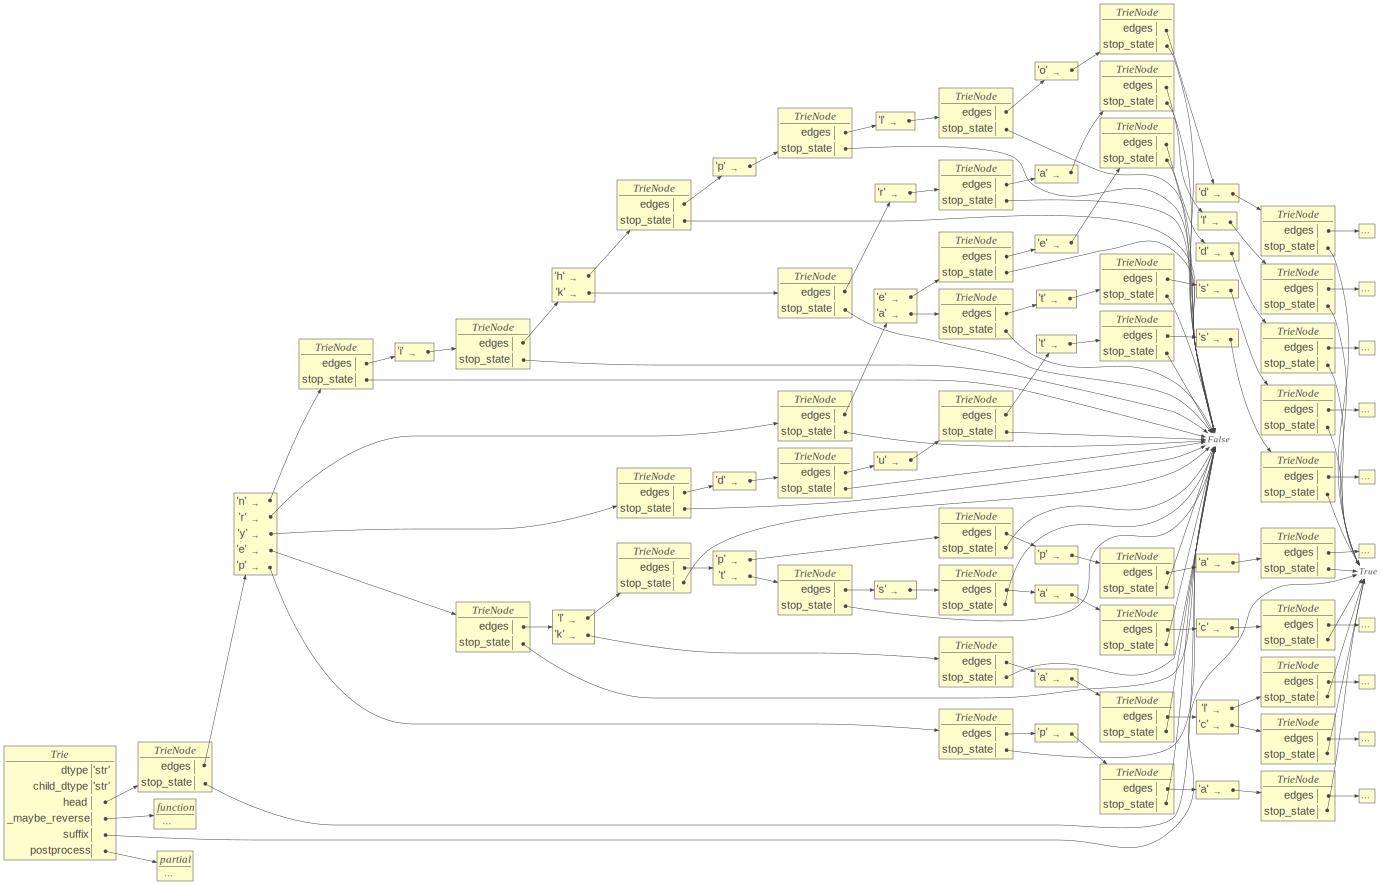

In [3038]:
t6 = Trie(['dolphin', 'deer'], suffix=True)
t6.append('star')
t6 += 'study'
t6 = t6 + 'apple'
t6.extend(['larkin', 'app'])
t6.append('castle')
t6.append('lake')
t6.append('cake')

objviz(t6)

In [3039]:
assert all(term in t6
           for term in ('dolphin', 'star', 'study', 'apple', 'larkin', 'app'))
assert 'zebra' not in t6
assert 'dolphin'[::-1] not in t6

In [3040]:
res = t6.startswith('ap')
print(res)
assert res == ['apple', 'app']

['apple', 'app']


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:170: UserWarning: Suffix trees are optimized for the `endswith` method, but `startswith` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `startswithwith`, you can create a prefix tree by  passing `suffix=False` to Trie.__init__.


In [3041]:
res = t6.endswith('in')
print(res)
assert res == ['dolphin', 'larkin']

['dolphin', 'larkin']


In [3042]:
res = t6.startswith('ni')
print(res)
assert not res

[]


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:170: UserWarning: Suffix trees are optimized for the `endswith` method, but `startswith` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `startswithwith`, you can create a prefix tree by  passing `suffix=False` to Trie.__init__.


In [3043]:
t6.values()

['dolphin',
 'larkin',
 'deer',
 'star',
 'study',
 'apple',
 'castle',
 'lake',
 'cake',
 'app']

In [3044]:
res = t6.longest_common_prefix('lard')
print(res)
assert res == ['larkin']

['larkin']


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:399: UserWarning: Suffix trees are optimized for the `longest_common_suffix` method, but `longest_common_prefix` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `endswith`, you can create a prefix tree by passing `suffix=False` to Trie.__init__.


In [3045]:
res = t6.longest_common_prefix('kin')
print(res)
assert not res

[]


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:399: UserWarning: Suffix trees are optimized for the `longest_common_suffix` method, but `longest_common_prefix` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `endswith`, you can create a prefix tree by passing `suffix=False` to Trie.__init__.


In [3046]:
res = t6.longest_common_suffix('zzxlkj')
print(res)
assert not res

[]


In [3047]:
res = t6.longest_common_suffix('fantastle')
print(res)
assert res == ['castle']

['castle']


In [3048]:
res = t6.longest_common_suffix('tle')
print(res)
assert res == ['castle']

['castle']


In [3049]:
res = t6.longest_common_suffix('acastle')
print(res)
assert res == ['castle']

['castle']


In [3050]:
def _longest_common_prefix(self, seq, seen):    
    # Validation and reversal happens in `startswith`.
    matches = self.startswith(seq)
    if matches: return matches
    node = self.head
    for i, x in enumerate(seq):
        if x in node.edges:
            seen.append(x)
            node = node.edges[x]
        elif i == 0:
            # Otherwise, all values are returned when the first item is 
            # not in the trie.
            return []
        else:
            matches = [self.postprocess(seen + list(v)) 
                       for v in self._values([], [], node)]
            # Otherwise, we get bug where an empty list is returned if
            # the longest matching prefix is a complete sequence and the
            # node has no edges.
            if node.stop_state and not matches: 
                matches.append(self.postprocess(seen))
            return matches
               
    # Case where the input sequence is present in the trie as a complete
    # sequence and it has no edges. This cannot be combined with the
    # case in the else statement above where matches is empty. We avoid
    # handling this upfront with something like 
    # `if seq in self: return [seq]` because we want to capture additional
    # valid sequences in present.
    if node.stop_state:
        return [self.postprocess(seen)]

def _longest_common_suffix(self, seq, seen):
    # TODO: refactor this into _longest_common_prefix. Just 
    # experimenting for now to get longest_common_suffix working.
    # AHA: Validation and reversal happens in `startswith` but if no matches
    # are found, we then act on the original sequence in the for loop.
    matches = self.endswith(seq) # diff: endswith vs startswith
    if matches: 
        print('found matches')
        return matches
    node = self.head
    for i, x in enumerate(self._maybe_reverse(seq)): # diff: reverse
        if x in node.edges:
            print('found x', x)
            seen.append(x)
            node = node.edges[x]
        elif i == 0:
            # Otherwise, all values are returned when the first item is 
            # not in the trie.
            print('first char not found')
            return []
        else:
            # Case where item not found in edges, i.e. the rest of the 
            # sequence will diverge from whatever is present in the trie.
            print('NOT FOUND', x, 'seen', seen)
            print('values', self._values([], [], node))
            # _values returns items postprocessed and reversed if necessary,
            # so do this to `seen` before combining.
            seen = self._maybe_reverse(self.postprocess(seen))
            matches = [v + seen for v in self._values([], [], node)]
            if node.stop_state and not matches: 
                print('no edges')
                matches.append(seen)
            return matches
        
    if node.stop_state:
        print('after for')
        return [self._maybe_reverse(self.postprocess(seen))] # diff: post

In [3086]:
res = t6.longest_common_suffix('acastle')
print(res)
assert res == ['castle']

['castle']


In [3087]:
res = t6.longest_common_suffix('jastle')
print(res)
assert res == ['castle']

['castle']


In [3053]:
res = t6.longest_common_suffix('haloparkin')
print(res)
assert res == ['larkin']

['larkin']


In [3054]:
res = t6.longest_common_suffix('truly')
print(res)
assert res == ['study']

['study']


In [3055]:
res = t6.longest_common_suffix('xyz')
print(res)
assert not res

[]


In [3056]:
res = t6.longest_common_suffix('deer')
print(res)
assert res == ['deer']

['deer']


In [3057]:
res = t6.longest_common_prefix('dollar')
print(res)
assert res == ['dolphin']

['dolphin']


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:399: UserWarning: Suffix trees are optimized for the `longest_common_suffix` method, but `longest_common_prefix` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `endswith`, you can create a prefix tree by passing `suffix=False` to Trie.__init__.


In [3058]:
res = t6.longest_common_prefix('blink')
print(res)
assert not res

[]


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:399: UserWarning: Suffix trees are optimized for the `longest_common_suffix` method, but `longest_common_prefix` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `endswith`, you can create a prefix tree by passing `suffix=False` to Trie.__init__.


Like startswith, there is no efficient implementation of longest_common_prefix for suffix tree. Need to do it brute force way.

In [3059]:
def brute_longest_common_prefix(self, seq):
    res = []
    for i in range(len(seq), 0, -1):
        for v in self.values():
            if v[:i] == seq[:i]: res.append(v)
        if res: break
    return res

In [3060]:
brute_longest_common_prefix(t6, 'zzz')

[]

In [3061]:
brute_longest_common_prefix(t6, 'dolphin')

['dolphin']

In [3062]:
brute_longest_common_prefix(t6, 'skid')

['star', 'study']

In [3063]:
brute_longest_common_prefix(t6, 'stack')

['star']

In [3064]:
brute_longest_common_prefix(t6, 'star')

['star']

In [3065]:
brute_longest_common_prefix(t6, 'starring')

['star']

### T7: list[str], suffix

Suffix tree where each sequence is a list of strings (NOT nested).

In [3066]:
t7 = Trie(suffix=True)
t7.append(['I',  'went', 'to', 'school', 'today', '.'])
t7.append(['I',  'like', 'horses', '.'])
t7.append(['He', 'is', 'home', 'early', '.'])
t7.append(['I', 'went', 'to', 'the', 'beach', '.'])
t7.append(['I', 'went', 'to', 'bed', 'early', '.'])

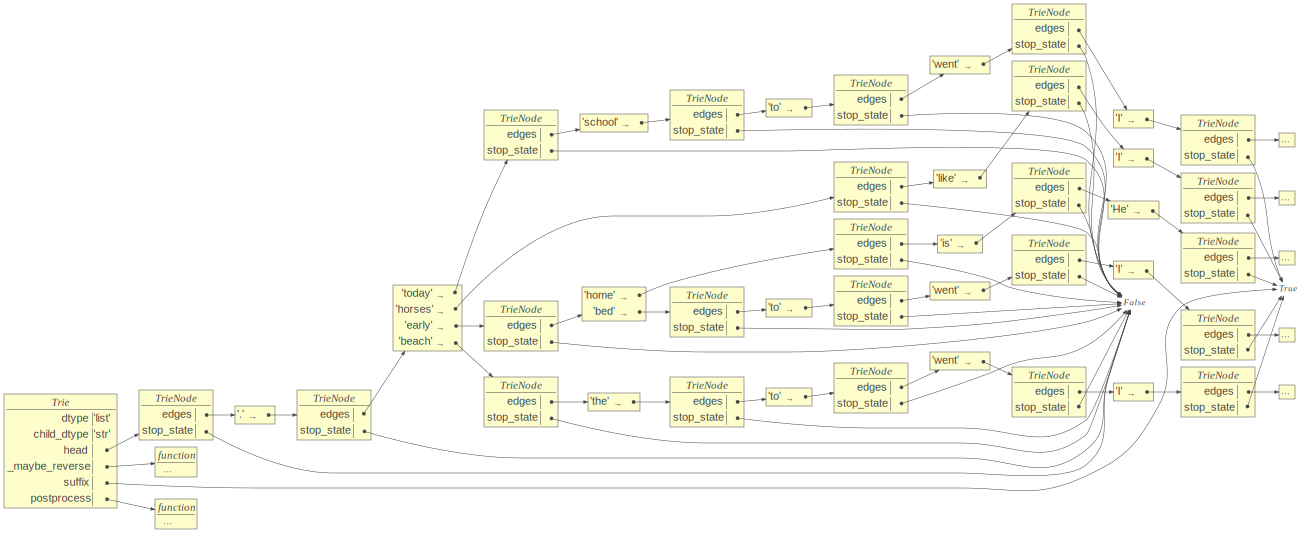

In [3067]:
objviz(t7)

In [3068]:
t7.values()

[['I', 'went', 'to', 'school', 'today', '.'],
 ['I', 'like', 'horses', '.'],
 ['He', 'is', 'home', 'early', '.'],
 ['I', 'went', 'to', 'bed', 'early', '.'],
 ['I', 'went', 'to', 'the', 'beach', '.']]

In [3069]:
res = t7.startswith(['I', 'went'])
print(res)
assert res == [['I', 'went', 'to', 'school', 'today', '.'],
               ['I', 'went', 'to', 'bed', 'early', '.'],
               ['I', 'went', 'to', 'the', 'beach', '.']]

[['I', 'went', 'to', 'school', 'today', '.'], ['I', 'went', 'to', 'bed', 'early', '.'], ['I', 'went', 'to', 'the', 'beach', '.']]


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:170: UserWarning: Suffix trees are optimized for the `endswith` method, but `startswith` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `startswithwith`, you can create a prefix tree by  passing `suffix=False` to Trie.__init__.


In [3070]:
res = t7.endswith(['like', 'horses', '.'])
print(res)
assert res == [['I', 'like', 'horses', '.']]

[['I', 'like', 'horses', '.']]


In [3071]:
res = t7.endswith(['I'])
print(res)
assert not res

[]


In [3072]:
res = t7.endswith(['early', '.'])
print(res)
assert res == [['He', 'is', 'home', 'early', '.'], 
               ['I', 'went', 'to', 'bed', 'early', '.']]

[['He', 'is', 'home', 'early', '.'], ['I', 'went', 'to', 'bed', 'early', '.']]


In [3073]:
res = t7.longest_common_prefix(['I', 'went', 'to', 'the', 'hospital', '.'])
print(res)
assert res == [['I', 'went', 'to', 'the', 'beach', '.']]

[['I', 'went', 'to', 'the', 'beach', '.']]


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:399: UserWarning: Suffix trees are optimized for the `longest_common_suffix` method, but `longest_common_prefix` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `endswith`, you can create a prefix tree by passing `suffix=False` to Trie.__init__.


In [3074]:
res = t7.longest_common_suffix(['I', 'went', 'to', 'the', 'hospital', '.'])
print(res)
assert res == [['I', 'went', 'to', 'school', 'today', '.'],
               ['I', 'like', 'horses', '.'],
               ['He', 'is', 'home', 'early', '.'],
               ['I', 'went', 'to', 'bed', 'early', '.'],
               ['I', 'went', 'to', 'the', 'beach', '.']]

[['I', 'went', 'to', 'school', 'today', '.'], ['I', 'like', 'horses', '.'], ['He', 'is', 'home', 'early', '.'], ['I', 'went', 'to', 'bed', 'early', '.'], ['I', 'went', 'to', 'the', 'beach', '.']]


In [3075]:
res = t7.longest_common_suffix(['I', 'went', 'to', 'sleep', 'early', '.'])
print(res)
assert res == [['He', 'is', 'home', 'early', '.'], 
               ['I', 'went', 'to', 'bed', 'early', '.']]

[['He', 'is', 'home', 'early', '.'], ['I', 'went', 'to', 'bed', 'early', '.']]


In [3076]:
res = t7.longest_common_suffix(['I', 'went', 'to', 'bed', 'early', '.'])
print(res)
assert res == [['I', 'went', 'to', 'bed', 'early', '.']]

[['I', 'went', 'to', 'bed', 'early', '.']]


In [3077]:
res = t7.longest_common_prefix(['I', 'went', 'home', 'late', '.'])
print(res)
assert res == [['I', 'went', 'to', 'school', 'today', '.'],
               ['I', 'went', 'to', 'bed', 'early', '.'],
               ['I', 'went', 'to', 'the', 'beach', '.']]

[['I', 'went', 'to', 'school', 'today', '.'], ['I', 'went', 'to', 'bed', 'early', '.'], ['I', 'went', 'to', 'the', 'beach', '.']]


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:399: UserWarning: Suffix trees are optimized for the `longest_common_suffix` method, but `longest_common_prefix` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `endswith`, you can create a prefix tree by passing `suffix=False` to Trie.__init__.


In [3078]:
res = t7.longest_common_prefix(['I', 'went', 'to'])
print(res)
assert res == [['I', 'went', 'to', 'school', 'today', '.'],
               ['I', 'went', 'to', 'bed', 'early', '.'],
               ['I', 'went', 'to', 'the', 'beach', '.']]

[['I', 'went', 'to', 'school', 'today', '.'], ['I', 'went', 'to', 'bed', 'early', '.'], ['I', 'went', 'to', 'the', 'beach', '.']]


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:399: UserWarning: Suffix trees are optimized for the `longest_common_suffix` method, but `longest_common_prefix` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `endswith`, you can create a prefix tree by passing `suffix=False` to Trie.__init__.


In [3079]:
res = t7.longest_common_prefix(['I', 'went', 'to', 'school', 'today', '.'])
print(res)
assert res == [['I', 'went', 'to', 'school', 'today', '.']]

[['I', 'went', 'to', 'school', 'today', '.']]


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:399: UserWarning: Suffix trees are optimized for the `longest_common_suffix` method, but `longest_common_prefix` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `endswith`, you can create a prefix tree by passing `suffix=False` to Trie.__init__.


In [3080]:
res = t7.longest_common_prefix(['I', 'went', 'to', 'school', 'today', '.', 
                                'Test'])
print(res)
assert res == [['I', 'went', 'to', 'school', 'today', '.']]

[['I', 'went', 'to', 'school', 'today', '.']]


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:399: UserWarning: Suffix trees are optimized for the `longest_common_suffix` method, but `longest_common_prefix` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `endswith`, you can create a prefix tree by passing `suffix=False` to Trie.__init__.


In [3081]:
# @debug
def _values(self, current=None, node=None):
    """Traverse all values starting from a given node and return them as a
    list. If a node is not explicitly provided, the head will be used and
    all values in the trie will be retrieved.
    """
    node = node or self.head
    current = current or []
    if node.stop_state:
        # Here, reversal is more of a postprocessing step than a 
        # preprocessing one: we're converting the reversed word stored in
        # the suffix tree back to its original order.
        yield self._maybe_reverse(self.postprocess(current))
    for key, node_ in node.edges.items():
        yield from _values(self, current+[key], node_)

In [3082]:
for v in _values(t):
    print('V', v)

V dolphin
V deer
V star
V study
V stunning
V sturdy
V stir
V stipend
V sorry
V app
V apple
V larkin
V lake
V castle
V cake
V car
V cold


In [3083]:
for x in _values(t):
    print(x, end=' ')

dolphin deer star study stunning sturdy stir stipend sorry app apple larkin lake castle cake car cold 